$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\lrg}{\large}$
$\newcommand{\where}{\ \text{where}\ }$
$\require{color}$
$\newcommand{\qw}{{\color{blue}{q(w)}}}$
$\newcommand{\sumJ}{\sum_{j=1}^{J}}$
$\newcommand{\D}{\mathcal{D}}$
$\newcommand{\ltxt}[1]{\large\text{#1}}$

$\ltxt{Sampling Methods}$

### $\ltxt{Approximations: deterministic vs. sampling  }$
<hr>
<br><br>

* $\text{Bayes function estimation e.g. by variational inference (deterministic):}$
<br><br>

$$\lrg{
\E[f(w)] = \int f(w) \cdot p(w| \D)\ dw \approx \int f(w)\cdot \qw\ dw, \where q(w) \approx p(w | \D)
}$$
<br><br>

* $\text{Estimation by sampling (non-deterministic):}$

$$\lrg{
\E[f(w)] = \int f(w) \cdot p(w| \D)\ dw \approx \frac{1}{J}\sumJ f(w^{(j)}), \where w^{(j)} \sim \underbrace{p(w | \D)}_{\color{blue}{\text{unknown}}}
}$$

### $\ltxt{Markov chain Monte Carlo (MCMC) methods}$

<br>

* $\text{Sampling methods drawn from unnormalized distributions}$

$$\lrg{
w^{(j)} \sim \underbrace{p(w | \D)}_{\color{blue}{\text{unknown}}} \propto \underbrace{p(\D, w)}_{\color{green}\text{known}} = \underbrace{\overbrace{p(\D | w)}^{\text{likelihood}}\cdot \overbrace{p(w)}^{\text{prior}}}_{\text{not normalized}}
}$$

### $\ltxt{Metropolis-Hastings (MH) algorithm (a general method):}$
<hr>
<center>
<img src='mcmc.png' width=600>

$\newcommand{\ws}{\ w^*  }$
$\newcommand{\wj}{\ w^{(j)} }$
$\newcommand{\wo}{\ w^{(j-1)} }$
$\require{amsmath}$

$\text{In the $j$-th iteration,}$

$\quad \quad 1)\ \text{Draw a sample}\ \lrg{
\ws \sim r(\ws | \wo ) \overbrace{=}^{\text{e.g.}}\ \mathcal{N}(\ws | \wo, \gamma)}$

$\quad \quad $2) Set the $j$-th sample to 

$${
\wj = \begin{cases}
    \ws & \text{with probability}\ T,\\
    \wo & \text{with probability}\ 1-T,
  \end{cases}
}$$
<br>
$$  \text{where the acceptance probability}\ T\ \text{satisfies the}\ \color{green}{\textbf{detailed balance property}}.$$

### $\ltxt{Detailed balance property}$
<hr><br>
$$\lrg{
T = \min\bigg(\ 1 \ ,\ \frac{p(\ws,\ \D\ )\cdot r(\wo | \ws )}{p (\wo, \D\ ) \cdot r(\ws | \wo)}\ \bigg)
}$$

### $\ltxt{Metropolis-Hastings algorithm}$

In [257]:
import numpy as np
from scipy.stats import expon, norm, gamma, bernoulli
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

### $\ltxt{Toy data generation}$
<hr>

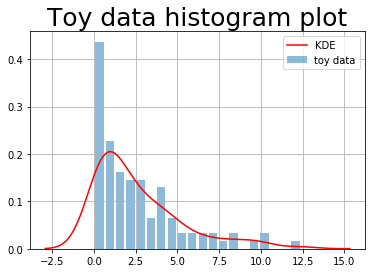

In [258]:
rate = 0.35 # True rate
D = np.sort(expon.rvs(loc=0,scale=1/rate,size=100, random_state=42))
# Histogram plot 
plt.hist(D,bins=20, rwidth=0.8, alpha=0.5, density=True,label='toy data')
sns.kdeplot(D, color='r', label='KDE')
plt.legend()
plt.title('Toy data histogram plot', fontsize=25)
_=plt.grid()

### $\ltxt{ Metropolis-Hastings ( MH ) algorithm implementation}$
<hr>

In [265]:
alpha = 1
beta = 0.5

def mh(D, steps = 5000):
    sigma  = 0.1
    w_prev = 0.1
    lkh=expon 
    prior=gamma
    W = []
    for i in tqdm(range(steps)):
        ws = np.abs(norm.rvs(loc=w_prev, scale=sigma))  # sample a new candidate entry    
        ln_p_ws_D = lkh.logpdf(D, scale=1/ws).sum() + prior.logpdf(ws, a=alpha, scale=1/beta) # ln(p(w*,D))      
        ln_p_w_prev_D = lkh.logpdf(D, scale=1/w_prev).sum() + prior.logpdf(w_prev, a=alpha, scale=1/beta)  # ln(p(w_{j-1}, D))     
        T = np.exp(np.min([0, ln_p_ws_D - ln_p_w_prev_D])) # log of the detailed balance property
        accept = bernoulli.rvs(p = T) # draw the acceptance probability
        if accept:
            w_prev = ws
            W.append(ws)            
    return np.array(W)

### $\ltxt{Run MH sampler}$
<hr>

In [260]:
W = mh(D,steps=10000)

100%|██████████| 10000/10000 [00:05<00:00, 1990.68it/s]


### $\ltxt{Plot estimated posterior from the MH samples}$
<hr>

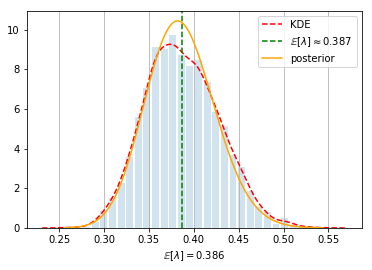

In [261]:
burn_in = 1000
W = W[burn_in:]

plt.hist(W, density=True, bins=30, rwidth=0.8, alpha=0.2)
sns.kdeplot(W, ls='--', color='r', label='KDE')
plt.axvline(W.mean(), ls='--', color='g', label= '$\\mathbb{E}[\lambda] \\approx $'+f'{W.mean():.3f}')

alpha_hat = alpha + len(D)
beta_hat = np.sum(D) + beta
space = np.linspace(W.min(),W.max(),500)
plt.plot(space, gamma.pdf(space,a=alpha_hat,scale=1/beta_hat), ls='-', color='orange', label='posterior')
plt.xlabel('$\\mathbb{E}[\lambda] = $'+ f'{alpha_hat/beta_hat:.3f}')
plt.grid(axis='x')
_=plt.legend()

### $\ltxt{Predictive density approximation}$
<hr>

$$\lrg{
p(x^* | \D, \alpha) = \int p(x^*,w | \D, \alpha)\ dw = \int p(x^* |\ w, \alpha)\cdot p(w | \D, \alpha)\ dw =
}$$

$$\boxed{\lrg{
\frac1 J \sumJ p(x^* | \wj ), \where \wj \sim q(w).
}}$$

In [262]:
from numpy import log
from scipy.special import loggamma as lgam
def pred_dist(x,X,alpha,beta): 
    alpha_hat = alpha + len(X)
    beta_hat = np.sum(X) + beta
    alpha_tilde = alpha_hat + 1
    beta_tilde = x + beta_hat
    ln_p = alpha_hat*log(beta_hat) + lgam(alpha_tilde) - (lgam(alpha_hat) + alpha_tilde*log(beta_tilde)) 
    return np.exp(ln_p)

### $\ltxt{Predictive density plot}$
<hr>

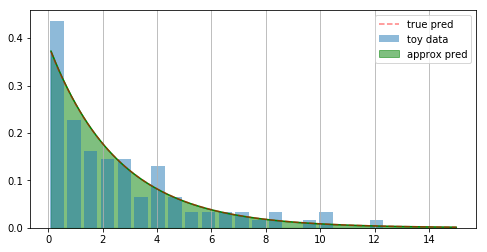

In [263]:
S = np.linspace(0.1,15,100)
pred = pred_dist(S,D,alpha,beta)
pred_approx = expon.pdf(S[:,None], scale=1./W[None]).mean(1) # <- Predictive density approximation
plt.figure(figsize=(8,4))
plt.hist(D,bins=20, rwidth=0.8, alpha=0.5, density=True,label='toy data')
plt.plot(S,pred_approx,color='g')
plt.plot(S,pred,color='r', ls='--', alpha=0.5, label='true pred')
plt.fill_between(S,0,pred_approx,alpha=0.5, color='g', label='approx pred')
plt.grid(axis='x')
_=plt.legend(loc=1)

### $\lrg{\text{Gibbs-sampling algorithm ( special case of MH algorithm ):}}$

<br><br>
<center>
<img src='gibbs.png' width=600>
<hr>

<br>
$\lrg{
\text{If}\ p(w_m | w_{\setminus m}, \D)\ \text{is in known form (sampler is available)},
}$

$\lrg{
\text{In the}\ j-\text{th iteration,} 
}$

$\lrg{\quad \quad 1)\ \text{Draw as}\ \textit{entry}\ w^*_m \sim p(w_m\ |\ w_{\setminus m}^{(j-1)} ), \ \text{and set}\ w^*_{\setminus m} = w_{\setminus w}^{(j-1)}.
}$

$\lrg{
\quad \quad 2)\ \text{Set}\ w_{m}^{(j)} = w^*_m\quad \color{red}\text{(with probability 1)}
}$

### $\ltxt{Gibbs sampling in latent Dirichlet allocation (LDA) }$
<hr>

* $\text{Topic Model}$

<center>
<img src='topics.png' width=1000>

### $\ltxt{Latent Dirichlet allocation model}$
<hr>
<center>
<img src='LDA.png' width=900>

* $\text{Model parameters}$

$${ 
M: \#\ \text{of documents}, \\
N: \#\ \text{of words in each document}, \\
V: \ \text{vocabulary size}, \\
K: \#\ \text{of topics}\ (\ \leq \min(M,V)\ ), \\
w^{(n,m)} \in \{0,1\}^{V} \leftarrow\ n\text{-th observed word in}\  m\text{-th document},\ W \in \{0, 1\}^{(N,M,V)}, \\
z^{(n,m)}\ \in \{0,1\}^{K} \leftarrow\ \text{topic assignment for}\ n\text{-th word in}\  m\text{-th document},\ Z \in \{0,1\}^{(N,M,K)}, \\
\Theta \in [0,1]^{(M,K)} \leftarrow\ \text{document-topic parameter}, \\
B \in [0,1]^{(K,V)}\ \leftarrow\ \text{topic-word parameter}, \\
\alpha_0, \eta_0 \leftarrow\ \text{hyperparameters}.
}$$

### $\ltxt{Model likelihood}$
<hr>

$${
p(w^{(n,m)} | \Theta, B ) = \prod_{v=1}^V\bigg( \sum_{k=1}^K \beta_{k,v} \cdot \theta_{m,k} \bigg)^{w_v^{(n,m)}}
}$$

$\newcommand{\zc} { z^{(n,m)} } $

* $\ltxt{Introducing the latent variable}\  z^{(n,m)}\ \text{changes sum to a product and makes the likelihood separable}.$
<br><br>

$$\lrg{
p(w^{(n,m)}, \zc \ |\ \Theta, B ) = \prod_{v=1}^V\bigg( \prod_{k=1}^K (\beta_{k,v} \cdot \theta_{m,k})^{\zc_k} \bigg)^{w_v^{(n,m)}} = 
}$$

$$\lrg{\prod_{k=1}^K \Big( \theta_{m,k}\Big)^{\zc_k}\prod_{v=1}^V \Big(\beta_{k,v}\Big)^{\zc_k}
}$$

### $\ltxt{Priors}$
<hr>

* $\text{Prior over document parameter}\ \Theta$

$$\lrg{
p(\Theta) \sim \text{Dir}(\Theta\ |\ \alpha_0) \propto \prod_{m=1}^M \prod_{k=1}^K \Big( \theta_{m,k}^{\ \alpha_0 - 1}\Big)
}$$

* $\text{Prior over topic-word parameter}$

$$\lrg{
p(B) \sim \text{Dir}(B\ |\ \eta_0) \propto \prod_{k=1}^K \prod_{v=1}^V \Big( \theta_{k,v}^{\ \eta_0 - 1}\Big)
}$$

### $\ltxt{Posterior} $
<HR>
$$\lrg{
p(Z, \Theta, B\ |\ W ) \propto p(W,Z | \Theta, B)\cdot p(\Theta)\cdot p(B) 
}$$

$$\lrg{
\propto \underbrace{\prod_{m=1}^M \prod_{n=1}^N \prod_{k=1}^K \Big( \theta_{m,h} \Big)^{\zc_k + (\alpha_0-1)/N}  \prod_{v=1}^V \Big(\beta_{k,v}^{w}\Big)^{w_v^{(n,m)}z_k^{(n,m)} + (\eta_0-1)/(MN)}}_{\text{Posterior is not in the known form.}} 
}$$

#### $\ltxt{Joint on}\ Z,\Theta, B\ \ltxt{is not in known form, but conditionals:}$

<hr>

$$\lrg{p(Z | \Theta, B, W) \propto \prod_{m=1}^M\prod_{n=1}^N\prod_{k=1}^K \bigg(\theta_{m,k}\prod_{v=1}^V w_v^{(n,m)}\bigg)^{z_k^{(n,m)}} \leftarrow \text{Multinomial}
}$$

$$\lrg{
p(\Theta | Z, W) \propto \prod_{m=1}^M\prod_{n=1}^N\prod_{k=1}^K \Big(\theta_{m,k}\Big)^{z_k^{(n,m)} + (\alpha_0 - 1)/N} \leftarrow \text{Dirichlet}
}$$

$$\lrg{
p(B | Z, W) \propto \prod_{m=1}^M\prod_{n=1}^N\prod_{k=1}^K \prod_{v=1}^V \Big(\beta_{k,v}^{w}\Big)^{w_v^{(n,m)}z_k^{(n,m)} + (\eta_0-1)/(MN)}  \leftarrow \text{Dirichlet}.
}$$

### $\ltxt{Gibbs sampling for LDA}$
<hr>

<br><br>

$\ltxt{In}\ j\ltxt{-th step,} $
<br><br>
$\lrg{\quad 1)\ \ \text{For each}\ (n,m)\ {\color{blue}{\text{independently}}}\ \text{draw}\ \Large{z^{(n,m)_{(j)}} \sim p( z^{(n,m)}\ |\ \Theta^{(j-1)}, B^{(j-1)},W)},
}$

$\lrg{
\quad 2)\ \ \text{For each}\ m\ {\color{blue}\text{independently}}\ \text{draw}\ \hat\theta_{m}^{(j)} \sim p(\hat\theta_m \ |\ Z^{(j)}, W),
}$

$\lrg{
\quad 3)\ \ \text{For each}\ k\ {\color{blue}\text{independently}}\ \text{draw}\ \hat\beta_{k}^{(j)} \sim p(\hat\beta_k \ |\ Z^{(j)}, W).
}$

<br><br>

* $\lrg{\text{Conditionaly independent sampling}\ \leftarrow\ \text{easy to parallelize !}}$ 

### $\ltxt{
Overview of the probabilistic models 
}$
<hr>
<br>
<center>
<img src='tax.png' width=1500>